# Evaluate the the Bayesian network

## Prepare the session

### Load the librairies

In [83]:
import pandas as pd

# To manipulate the model object
import bnlearn as bn

# To import the model
from joblib import load
import os

# To calculate ROC cruve (AUC) scores
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

### Import the model and test data objects

In [84]:
# Define the parent directory
parent_dir = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir)
)

# Define the subfolder directory
output_folder = os.path.join(
    parent_dir, "outputs"
)

# Name of the model output file
file_name1 = "test-data.joblib"
file_name2 = "BayesNet-fit.joblib"

test_df = load(
    os.path.join(output_folder, file_name1)
)

DAG = load(
    os.path.join(output_folder, file_name2)
)

## Predict based on the testing data

In [85]:
preds = bn.predict(DAG, test_df, variables = "hunting_success")

[bnlearn]> Remaining columns for inference: 8


100%|██████████| 22310/22310 [05:31<00:00, 67.32it/s]


In [148]:
len(preds)

28923

## AUC scores

### AUC scores for each class separately - One vs Rest (OvR)

Here, we are treating each class as a one vs rest where 1 is the value in the range 0 to 4 we are interested in (positive class), and 0 is any other value (negative class).

In [86]:
true_y = test_df["hunting_success"]

# Convert raw classes to one-hot encoding
true_y_one_hot = label_binarize(
    true_y.to_numpy(),
    classes = np.arange(5)
)

# Convert preds to numpy array
preds = np.array(preds)

# Calculate ROC AUC for each class
auc_scores = []
for class_idx in range(5):
    # Extract the true labels and predicted probabilities for the current class
    true_y_class = true_y_one_hot[:, class_idx]
    # Second column contains probabilities
    preds_class_prob = preds[:, 1]

    # Calculate ROC AUC score for the current class
    auc_score = roc_auc_score(true_y_class, preds_class_prob)
    auc_scores.append(auc_score)

# Print AUC scores for each class
for class_idx, auc_score in enumerate(auc_scores):
    print(f"AUC for Class {class_idx}: {auc_score}")

AUC for Class 0: 0.6577878795398381
AUC for Class 1: 0.42904596291627695
AUC for Class 2: 0.3636884701352926
AUC for Class 3: 0.46097429670779083
AUC for Class 4: 0.5538782841507162


### Plot AUC scores

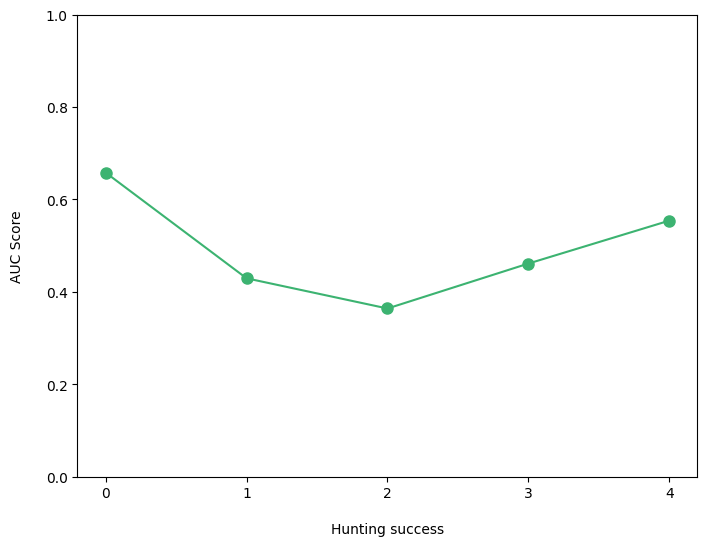

In [87]:
import matplotlib.pyplot as plt

# AUC scores for each class
success_indices = range(5)

# Plot
plt.figure(figsize = (8, 6))
plt.plot(
    success_indices, auc_scores,
    marker = "o", markersize = 8,
    color = "mediumseagreen",
    linestyle = '-'
)
plt.xlabel("\nHunting success")
plt.ylabel('AUC Score\n')
plt.ylim([0, 1])
plt.xticks(success_indices)
plt.grid(False)
plt.show()

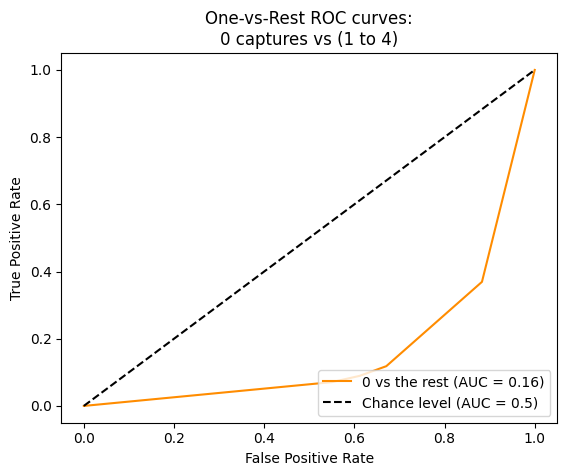

In [156]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

class_of_interest = 0

display = RocCurveDisplay.from_predictions(
    true_y_one_hot[:, 0],
    preds[:, 0],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n0 captures vs (1 to 4)",
)